In [6]:
import pandas_datareader as pdr
import pandas as pd

In [7]:
!pip install yfinance

In [8]:
import yfinance as yf

In [9]:
df = yf.download('AAPL')

/tmp/ipython-input-9-1245671487.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL')
[*********************100%***********************]  1 of 1 completed


In [10]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
1980-12-12,0.098597,0.099025,0.098597,0.098597,469033600
1980-12-15,0.093453,0.093881,0.093453,0.093881,175884800
1980-12-16,0.086594,0.087022,0.086594,0.087022,105728000
1980-12-17,0.088737,0.089166,0.088737,0.088737,86441600
1980-12-18,0.091310,0.091738,0.091310,0.091310,73449600


In [11]:
df.tail()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-06-23,201.500000,202.300003,198.960007,201.630005,55814300
2025-06-24,200.300003,203.440002,200.199997,202.589996,54064000
2025-06-25,201.559998,203.669998,200.619995,201.449997,39525700
2025-06-26,201.000000,202.639999,199.460007,201.429993,50799100
2025-06-27,201.080002,203.220001,200.000000,201.889999,73114100


Code according to close price

In [12]:
df1=df.reset_index()['Close']
df1.head()

Ticker,AAPL
0,0.098597
1,0.093453
2,0.086594
3,0.088737
4,0.091310


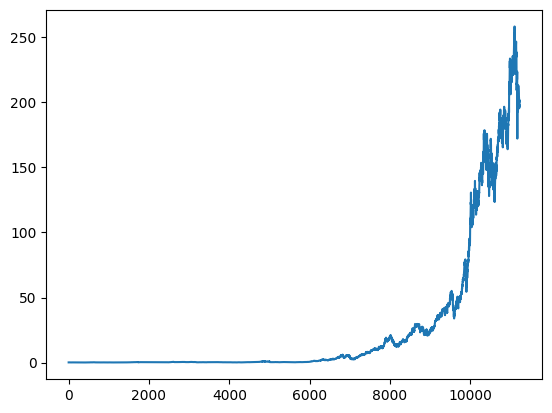

In [13]:
import matplotlib.pyplot as plt
plt.plot(df1)

LSTM is sensitive to scale so we apply MinMax scaler.

In [14]:
import numpy as np

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [16]:
df1.shape

(11226, 1)

Split data into training and testing

In [17]:
training_size=int(len(df1)*0.75)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

convert array into dataset matrix

In [18]:
def create_dataset(dataset,time_step=1):
  dataX,dataY=[],[]
  for i in range(len(dataset)-time_step-1):
    a=dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i+time_step,0])
  return np.array(dataX),np.array(dataY)

In [19]:
time_step=100
X_train,y_train=create_dataset(train_data,time_step)
X_test,y_test=create_dataset(test_data,time_step)

In [20]:
X_train

array([[0.00023561, 0.0002157 , 0.00018915, ..., 0.00022898, 0.00022732,
        0.00021736],
       [0.0002157 , 0.00018915, 0.00019745, ..., 0.00022732, 0.00021736,
        0.00022234],
       [0.00018915, 0.00019745, 0.00020741, ..., 0.00021736, 0.00022234,
        0.00022566],
       ...,
       [0.06675395, 0.06617167, 0.06798712, ..., 0.06420496, 0.06336381,
        0.06857046],
       [0.06617167, 0.06798712, 0.06782833, ..., 0.06336381, 0.06857046,
        0.06907517],
       [0.06798712, 0.06782833, 0.06817722, ..., 0.06857046, 0.06907517,
        0.0717559 ]])

Reshaping X_train for LSTM

In [21]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

Creating Stacked LSTM Model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [23]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 7.8187e-05 - val_loss: 0.0051
Epoch 2/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.3652e-06 - val_loss: 0.0048
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.1695e-06 - val_loss: 0.0056
Epoch 4/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.2789e-06 - val_loss: 0.0041
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7512e-06 - val_loss: 0.0048
Epoch 6/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.4328e-06 - val_loss: 0.0054
Epoch 7/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.0234e-06 - val_loss: 0.0039
Epoch 8/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.5771e-06 - val_loss: 0.0023
Epoch 9/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.0911e-06 - val_loss: 0.0029
Epoch 10/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.0720e-06 - val_loss: 0.0028
Epoch 11/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.1904e-06 - val

In [26]:
import tensorflow as tf

In [27]:
tf.__version__

'2.18.0'

In [28]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [29]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [30]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

5.128793866436555

In [31]:
math.sqrt(mean_squared_error(y_test,test_predict))

110.9679447713218

Plot

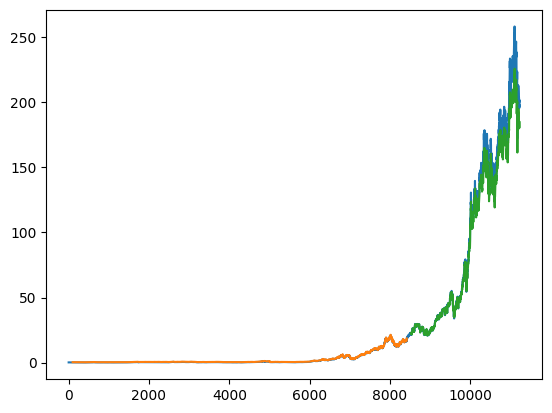

In [32]:
look_back=100
trainPredictPlot=np.empty_like(df1)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:]=train_predict
testPredictPlot=np.empty_like(df1)
testPredictPlot[:,:]=np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1,:]=test_predict
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [33]:
len(test_data)

2807

In [34]:
x_input=test_data[2806:].reshape(1,-1)
x_input.shape

(1, 1)

In [35]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [36]:
from numpy import array
lst_output=[]
n_steps=100
i=0

# Initialize temp_input with the last n_steps from test_data
temp_input=test_data[len(test_data)-n_steps:].reshape(1,-1).tolist()[0]

while(i<30):
  if(len(temp_input)>n_steps):
    x_input=np.array(temp_input[1:])
    x_input=x_input.reshape(1,-1)
    x_input=x_input.reshape((1,n_steps,1))
    yhat=model.predict(x_input,verbose=0)
    temp_input.extend(yhat[0].tolist())
    temp_input=temp_input[1:]
    lst_output.extend(yhat.tolist())
  else:
    x_input = np.array(temp_input)
    x_input = x_input.reshape((1, n_steps, 1))
    yhat = model.predict(x_input, verbose=0)
    temp_input.extend(yhat[0].tolist())
    lst_output.extend(yhat.tolist())
  i += 1 # Move the increment outside the else block

print(lst_output)

[[0.713215172290802], [0.6857994794845581], [0.6517027616500854], [0.6183359622955322], [0.5879569053649902], [0.561430811882019], [0.5390591621398926], [0.5207269191741943], [0.5059929490089417], [0.4941997230052948], [0.48459020256996155], [0.47641322016716003], [0.469006210565567], [0.4618482291698456], [0.45458361506462097], [0.4470188319683075], [0.439100444316864], [0.43088197708129883], [0.42248615622520447], [0.41406920552253723], [0.4057908356189728], [0.3977910876274109], [0.3901766240596771], [0.38301393389701843], [0.3763296604156494], [0.3701155185699463], [0.3643362820148468], [0.35893943905830383], [0.35386431217193604], [0.3490500748157501]]


In [37]:
lst_output

[[0.713215172290802],
 [0.6857994794845581],
 [0.6517027616500854],
 [0.6183359622955322],
 [0.5879569053649902],
 [0.561430811882019],
 [0.5390591621398926],
 [0.5207269191741943],
 [0.5059929490089417],
 [0.4941997230052948],
 [0.48459020256996155],
 [0.47641322016716003],
 [0.469006210565567],
 [0.4618482291698456],
 [0.45458361506462097],
 [0.4470188319683075],
 [0.439100444316864],
 [0.43088197708129883],
 [0.42248615622520447],
 [0.41406920552253723],
 [0.4057908356189728],
 [0.3977910876274109],
 [0.3901766240596771],
 [0.38301393389701843],
 [0.3763296604156494],
 [0.3701155185699463],
 [0.3643362820148468],
 [0.35893943905830383],
 [0.35386431217193604],
 [0.3490500748157501]]

In [38]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [39]:
import matplotlib.pyplot as plt

In [40]:
len(df1)

11226

In [41]:
df3=df1.tolist()
df3.extend(lst_output)

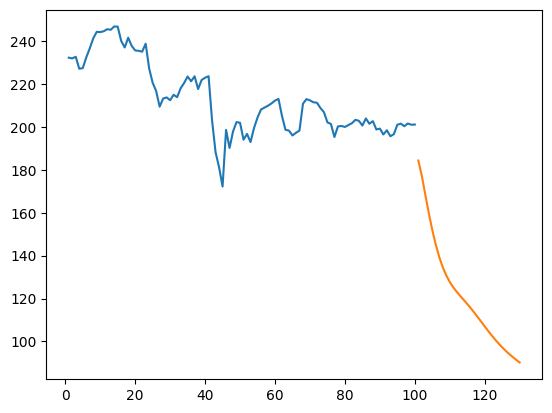

In [42]:
plt.plot(day_new,scaler.inverse_transform(df1[11126:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

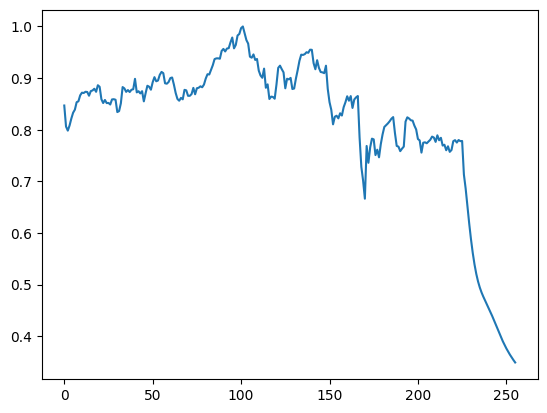

In [45]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[11000:])